In [31]:
import os
import numpy as np
from scipy.misc import imread
from matplotlib import pyplot as plt
from skimage import transform
import xml.etree.ElementTree as ET
from glob import glob
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import random
from collections import namedtuple

In [11]:
from keras.layers import Input, Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization, Reshape, Concatenate, Add


Using TensorFlow backend.


In [21]:
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )

In [58]:
images = []
categs = []
file_name = []
patches_X = []
patches_Y = []
iou = []
patch_size = 112
n_try_patch = 5 
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0
def build_dataset(data_path):
    data = glob(os.path.join(data_path,"*","*","*","*.jpg"))
    count = 0
    for file in data:
        image = imread(file, mode="RGB")
        img_name = file.split('/')[-1].split('.')[0]
        annotation_path = data_path +'/VOCdevkit/VOC2007/Annotations/'+img_name + '.xml'
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        img_H,img_W = image.shape[:2]
        print(img_H,img_W)
        xmin_b = []
        ymin_b = []
        xmax_b = []
        ymax_b = []
        for child in root:
            if child.tag == 'object':
                if child[0].tag == 'name':
                    if child[0].text in classes:
                        xmin = int(child[4][0].text)
                        ymin = int(child[4][1].text)
                        xmax = int(child[4][2].text)
                        ymax = int(child[4][3].text)
                        cropped = image[xmin:xmax,ymin:ymax]
                        images.append(cropped)
                        categ = np.zeros(4)
                        if child[0].text == classes[0]:
                            categ[0] = 1
                        elif child[0].text == classes[1]:
                            categ[1] = 1
                        elif child[0].text == classes[2]:
                            categ[2] = 1
                        elif child[0].text == classes[3]:
                            categ[3] = 1
                        categs.append(categ)
#                 background
                xmin_b.append(child[4][0].text)
                ymin_b.append(child[4][1].text)
                xmax_b.append(child[4][2].text)
                ymax_b.append(child[4][3].text)
        patch_x = 0
        patch_y = 0
        IoU = 9999999999
        for i in range(n_try_patch):
            p_x = random.randint(0,img_W-64)
            p_y = random.randint(0,img_H-64)
            I=0
            for j in range(len(ymin_b)):
                ra = Rectangle(p_x,p_y,p_x+patch_size,p_y+patch_size)
                rb = Rectangle(int(xmin_b[j]),int(ymin_b[j]),int(xmax_b[j]),int(ymax_b[j]))
                I += area(ra, rb)      
            if I < IoU:
                IoU = I
                patch_x = p_x
                patch_y = p_y
        print('intersection',IoU)
        file_name.append(file)
        patches_X.append(patch_x)
        patches_Y.append(patch_y)
        iou.append(IoU)


                            
        count += 1
        if count == 5:
            break
build_dataset('VOCtrainval_06-Nov-2007')
# plt.imshow(images[5])
# plt.show()
# print(categs[5])
print(len(iou))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


332 500
intersection 4144
500 375
intersection 0
375 400
intersection 0
375 500
intersection 528
375 500
intersection 3024
5


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


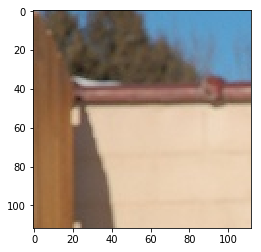

In [53]:
image = imread(file_name[0], mode="RGB")
plt.imshow(image[patches_Y[0]:patches_Y[0]+patch_size,patches_X[0]:patches_X[0]+patch_size])
    
    
    

In [4]:
# Load the pretrained model
model = models.resnet18(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

In [10]:
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [7]:
def get_vector(image):
    # 1. Load the image with Pillow library
#     img = Image.open(image)
    img = Image.fromarray(image)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data[0,:,0,0])
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding


In [12]:
l1 = get_vector(images[8])

In [14]:
l1.shape

torch.Size([512])